In [7]:
import numpy as np      
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import datetime
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OrdinalEncoder

## Visualization

In [2]:
NY = pd.read_csv('NY.csv')
#NEW
NY['Start_Time'] = pd.to_datetime(NY['Start_Time'])
NY

Severity          Start_Time  Start_Lat  Start_Lng  Distance(mi)  \
0             2 2016-11-30 15:58:59  40.850020 -73.943990         0.899   
1             2 2016-11-30 17:13:53  41.311771 -74.121299        12.791   
2             2 2016-11-30 17:12:20  43.039261 -76.142130         0.240   
3             2 2016-11-30 17:31:55  40.771460 -73.946580         0.226   
4             2 2016-11-30 17:46:05  42.657380 -73.741570         1.197   
...         ...                 ...        ...        ...           ...   
56611         2 2019-08-23 16:48:32  40.731626 -73.872164         0.000   
56612         2 2019-08-23 16:16:21  40.969130 -73.816990         0.000   
56613         2 2019-08-23 16:40:16  40.689860 -73.567770         0.075   
56614         2 2019-08-23 19:20:28  40.601750 -74.060440         1.627   
56615         2 2019-08-23 17:51:33  40.717320 -73.831200         0.698   

                      Street Side            City       County State  ...  \
0      George Washington Brg    R        New York     New York    NY  ...   
1                     I-87 S    R  Central Valley       Orange    NY  ...   
2                     I-81 S    R        Syracuse     Onondaga    NY  ...   
3                   FDR Dr S    R        New York     New York    NY  ...   
4                    I-787 N    R          Albany       Albany    NY  ...   
...                      ...  ...             ...          ...   ...  ...   
56611     Long Island Expy W    R        Elmhurst       Queens    NY  ...   
56612             Leewood Dr    R        Tuckahoe  Westchester    NY  ...   
56613  Southern State Pkwy W    R         Merrick       Nassau    NY  ...   
56614                I-278 E    R   Staten Island     Richmond    NY  ...   
56615   Grand Central Pkwy E    R    Forest Hills       Queens    NY  ...   

      Duration Precipitation(NA)  Clear  Cloud   Rain  Heavy_Rain   Snow  \
0            6                 0  False  False   True       False  False   
1            6                 1  False  False   True       False  False   
2            6                 1  False   True  False       False  False   
3            6                 0  False  False   True       False  False   
4            6                 0  False  False   True       False  False   
...        ...               ...    ...    ...    ...         ...    ...   
56611        0                 0  False   True  False       False  False   
56612        0                 0  False   True  False       False  False   
56613        0                 0  False  False  False       False  False   
56614        0                 0  False   True  False       False  False   
56615        0                 0  False   True  False       False  False   

      Heavy_Snow    Fog   Dust  
0          False  False  False  
1          False  False  False  
2          False  False  False  
3          False  False  False  
4          False  False  False  
...          ...    ...    ...  
56611      False  False  False  
56612      False  False  False  
56613      False  False  False  
56614      False  False  False  
56615      False  False  False  

[56616 rows x 46 columns]

# Graph 1
## 讲述逻辑：先看一下整个dataset的severity分布是怎么样的，发现2非常多，1非常少，于是想分年份看一下是不是每年都这样

Text(0.5, 1.0, 'Severity level')

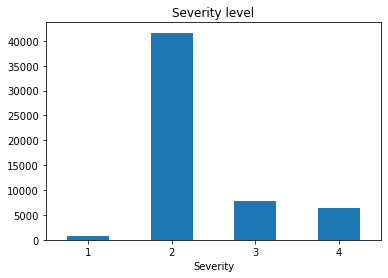

In [235]:
NY.groupby('Severity').size().plot(kind="bar")
plt.xticks(rotation=360)
plt.title('Severity level')

# Graph 2
## 分年份观察后发现2020年的数据明显增多，而且只有2020年一年有level1的数据，推测dataset本身有问题，不同年份的数据收集方法可能不同，为了预防由此可能导致的问题，我们决定仅选择2020年一年的数据进行后续分析

In [3]:
NY["Year"] = pd.DatetimeIndex(NY['Start_Time']).year

Text(0.5, 1.0, 'Plot by Year and Severity')

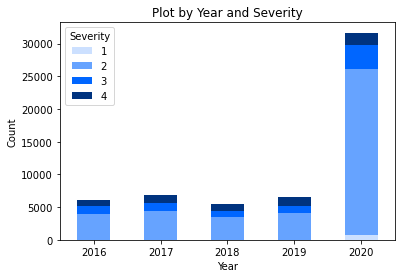

In [8]:
plot1 = NY.groupby(["Year", "Severity"]).size().unstack().plot(kind = 'bar', stacked = True, cmap = mpl.colors.ListedColormap(['#CCE0FF', '#66A3FF','#0066FF', '#00337F']))
plot1.set_ylabel("Count")
plt.xticks(rotation=360)
plot1.set_title("Plot by Year and Severity")

In [9]:
NY_2020 = NY[NY['Year']==2020]

In [10]:
NY_2020 = NY_2020.reset_index(drop=True)

# Graph 3
## 整合4个day night column并观察对应的severity发现白天车祸数量多，且相对严重的车祸占比也更高，所以想explore其他不同时间段车祸数量的分布及severity的不同

In [11]:
#New
NY_2020["Day_Night"] = 0

for i in range(len(NY_2020)):
    t1, t2, t3, t4 = NY_2020.Sunrise_Sunset[i], NY_2020.Civil_Twilight[i], NY_2020.Nautical_Twilight[i], NY_2020.Astronomical_Twilight[i]
    timedict = {"Day": 1, "Night": 0}
    if sum([timedict[t1], timedict[t2], timedict[t3], timedict[t4]]) > 2:
        NY_2020["Day_Night"][i] = "Day"
    elif sum([timedict[t1], timedict[t2], timedict[t3], timedict[t4]]) < 2:
        NY_2020["Day_Night"][i] = "Night"
    elif sum([timedict[t1], timedict[t2], timedict[t3], timedict[t4]]) == 2 & 19 < NY_2020.Start_Time[i].hour < 6:
        NY_2020["Day_Night"][i] = "Night"
    else:
        NY_2020["Day_Night"][i] = "Day"

<ipython-input-11-e9e7f8d31526>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NY_2020["Day_Night"][i] = "Night"
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-e9e7f8d31526>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NY_2020["Day_Night"][i] = "Day"
<ipython-input-11-e9e7f8d31526>:14: SettingWithCo

In [14]:
NY_2020["DaysOfWeek"] = pd.DatetimeIndex(NY_2020['Start_Time']).weekday
days = ['Mon','Tue', "Wed", "Thu", "Fri", "Sat", "Sun"]

In [15]:
NY_2020['Weekend'] = np.where(((NY_2020['DaysOfWeek']==6) | (NY_2020['DaysOfWeek']==5)), True, False)

Text(0.5, 1.0, 'Plot by Day_Night with severity distribution')

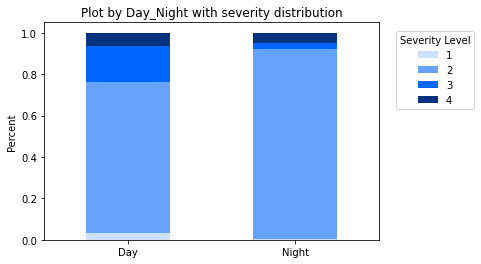

In [20]:
NY_2020.groupby(["Day_Night","Severity"]).size().transform(lambda x: x/x.sum(level=0)).unstack().plot(kind='bar', stacked=True, cmap = mpl.colors.ListedColormap(['#CCE0FF', '#66A3FF','#0066FF', '#00337F']))
plt.ylabel('Percent')
plt.xlabel('')
plt.xticks(rotation=360)
plt.legend(loc=(1.05,0.6),title='Severity Level')
plt.title("Plot by Day_Night with severity distribution")

Text(0.5, 1.0, 'Accident severity distribution on weekdays and weekends')

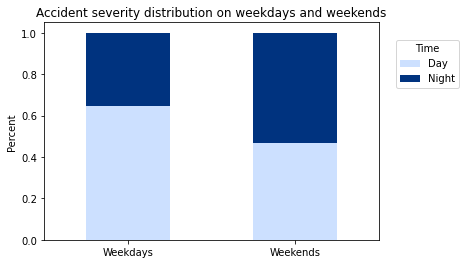

In [44]:
NY_2020.groupby(["Weekend","Day_Night"]).size().transform(lambda x: x/x.sum(level=0)).unstack().plot(kind='bar', stacked=True, cmap = mpl.colors.ListedColormap(['#CCE0FF', '#66A3FF','#0066FF', '#00337F']))
plt.ylabel('Percent')
plt.xlabel('')
positions = (0, 1)
labels = ("Weekdays", "Weekends")
plt.xticks(positions,labels)
plt.xticks(rotation=360)
plt.legend(loc=(1.05,0.7),title='Time')
plt.title("Accident severity distribution on weekdays and weekends")

In [58]:
NY_2020.groupby(["Weekend",'Day_Night'])['Severity'].mean()

Weekend  Day_Night
False    Day          2.261570
         Night        2.102970
True     Day          2.316190
         Night        2.178605
Name: Severity, dtype: float64

In [53]:
severe = pd.DataFrame(NY_2020.groupby(["Day_Night","Severity","Weekend"]).size())
severe

0
Day_Night Severity Weekend       
Day       1        False      650
                   True        18
          2        False    12082
                   True      2046
          3        False     2810
                   True       503
          4        False     1096
                   True       194
Night     1        False       22
                   True         3
          2        False     8473
                   True      2822
          3        False      232
                   True       119
          4        False      363
                   True       225

# Graph 4
## 以小时为单位发现下午车祸多，严重性低，上午车祸少，严重性高

In [7]:
NY_2020["Hour"] = pd.DatetimeIndex(NY_2020['Start_Time']).hour
Hour = NY_2020.groupby(["Hour"])["Severity"].agg(['mean','count'])

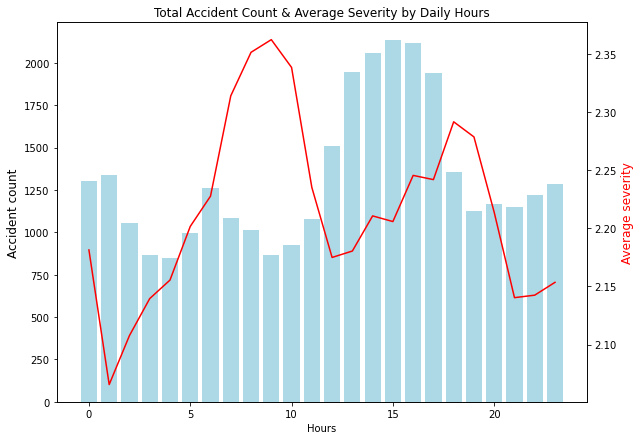

In [255]:
fig, ax1 = plt.subplots(figsize = (9,6))
x = Hour.index
ax1.set_xlabel('Hours')
y1 = Hour['count']
ax1.bar(x, y1,color='lightblue')
#ax1.bar(x, y1,color=['lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue','pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'pink','lightblue', 'lightblue', 'lightblue', 'lightblue'])
ax1.set_ylabel('Accident count', fontsize=12)

ax2 = ax1.twinx()
y2 = Hour['mean']
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('Average severity', color='r', fontsize=12)

fig.tight_layout()
plt.title('Total Accident Count & Average Severity by Daily Hours')
plt.show()

# Graph 5
## 星期几vs. count &  average severity, 发现周末车祸少，但更严重，尤其是星期天，周四是平均车祸最多的一天，但严重程度最低

In [32]:
DoW = pd.DataFrame(NY_2020.groupby(["DaysOfWeek"])["Severity"].mean())
DoW2 = pd.DataFrame(NY_2020.groupby(["DaysOfWeek"])["Severity"].size())

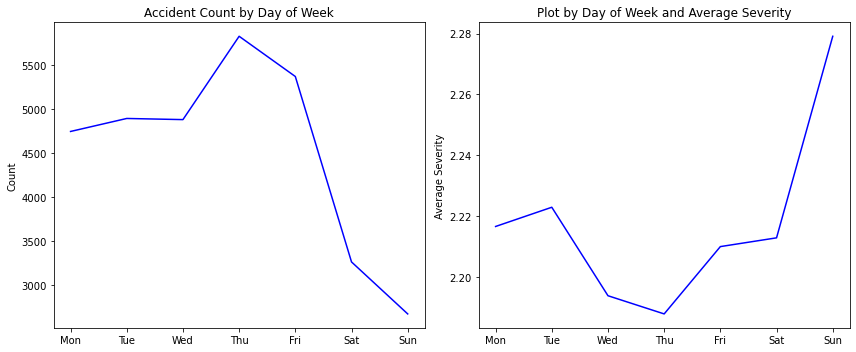

In [33]:
fig,(ax2,ax1) = plt.subplots(1,2,figsize = (12,5))

x = days
ax1.set_xlabel('')
y1 = DoW['Severity']
ax1.plot(x, y1,color='blue')
ax1.set_ylabel('Average Severity')
ax1.set_title('Plot by Day of Week and Average Severity')

x = days
ax2.set_xlabel('')
y1 = DoW2['Severity']
ax2.plot(x, y1,color='blue')
ax2.set_ylabel('Count')
ax2.set_title('Accident Count by Day of Week')

fig.tight_layout()
plt.show()


# Graph 6
## Density Map 发现有些区域车祸很多，有些很少，同时严重的车祸似乎集中在一些主干道上，促使我们想以road type为基准观察一下车祸严重性

In [59]:
#NYC map 
fig = px.density_mapbox(NY_2020, lat='Start_Lat', lon='Start_Lng', z='Severity', hover_name='Street', radius=5,
                        center=dict(lat=40.7831, lon=-73.9712), zoom=8,
                        mapbox_style="open-street-map", height=900)
fig.show()

# Graph 7
## 以county为单位观察

In [78]:
County = NY_2020.groupby(["County"])["Severity"].agg(['mean','count']).sort_values(by='count', ascending=False).head(15)

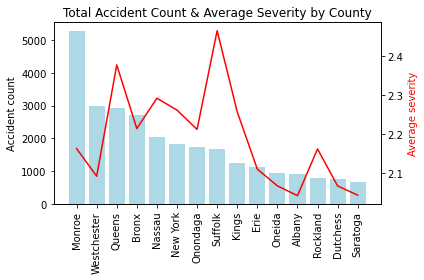

In [79]:
#county和严重程度
fig, ax1 = plt.subplots()
x = County.index
plt.xticks(rotation=90)
ax1.set_xlabel('')
y1 = County['count']
ax1.bar(x, y1,color='lightblue')
ax1.set_ylabel('Accident count')

ax2 = ax1.twinx()
y2 = County['mean']
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('Average severity', color='r')

plt.title('Total Accident Count & Average Severity by County')
fig.tight_layout()
plt.show()

# Graph 8
## 以street为单位发现最常发生车祸的路名中I-和Expy非常多，引入text analysis

In [80]:
street = NY_2020.groupby(["Street"])["Severity"].agg(['mean','count']).sort_values(by='count', ascending=False).head(15)

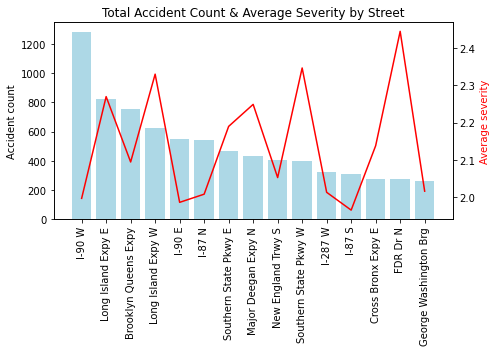

In [236]:
fig, ax1 = plt.subplots(figsize = (7,5))
x = street.index
plt.xticks(rotation=90)
ax1.set_xlabel('')
y1 = street['count']
ax1.bar(x, y1,color='lightblue')
ax1.set_ylabel('Accident count')

ax2 = ax1.twinx()
y2 = street['mean']
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('Average severity', color='r')

plt.title('Total Accident Count & Average Severity by Street')
fig.tight_layout()
plt.show()

# Graph 9
## frequency & word cloud

In [9]:
NY_2020.loc[:, 'Streetname'] = NY_2020['Street']

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Xinwei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Xinwei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Xinwei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
NY_2020['Streetname'] = NY_2020['Streetname'].str.replace('[0-9]+', '')
NY_2020['Streetname'].head()

#remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english') + ['W','S','E','N']
NY_2020['Streetname'] = NY_2020['Streetname'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [12]:
NY_2020['Streetname'] = NY_2020['Streetname'].str.replace('Road', 'Rd')
NY_2020['Streetname'] = NY_2020['Streetname'].str.replace('Highway', 'Hwy')
NY_2020['Streetname'] = NY_2020['Streetname'].str.replace('Avenue', 'Ave')
NY_2020['Streetname'] = NY_2020['Streetname'].str.replace('Bridge', 'Brg')

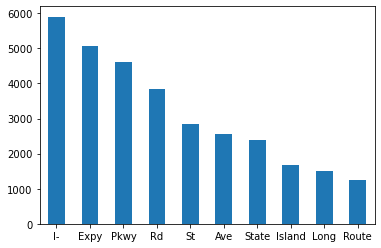

In [199]:
freq = pd.Series(' '.join(NY_2020['Streetname']).split()).value_counts()[:10]
freq.plot(kind ="bar")
plt.xticks(rotation = 360)
plt.show()

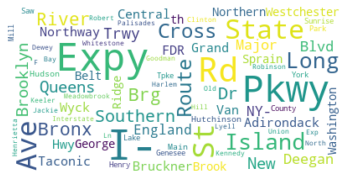

In [200]:
sequence = pd.Series(' '.join(NY_2020['Streetname']).split()).value_counts()
sequence = pd.DataFrame(sequence)
sequence.dtypes
sequence_a = pd.to_numeric(sequence[0])
wordcloud = WordCloud(max_font_size=50, max_words=80, background_color="white").generate_from_frequencies(sequence_a)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Graph 10
## Correlation Matrix TO BE UPDATED

In [13]:
#添加street_type column
NY_2020[["Streetname", "Street_type"]] = NY_2020["Streetname"].str.rsplit(pat=" ", n=1, expand=True)
NY_2020.Street_type = np.where(NY_2020.Street_type.isnull(), NY_2020.Streetname, NY_2020.Street_type)

In [210]:
#选出最frequent的20种streety type
Street_type = NY_2020['Street_type'].value_counts()[:20].index.tolist()

In [221]:
#增加Status栏
NY_2020['Status'] = np.where(((NY_2020['Severity']==3) | (NY_2020['Severity']==4)), 'Severe', 'Not Severe')

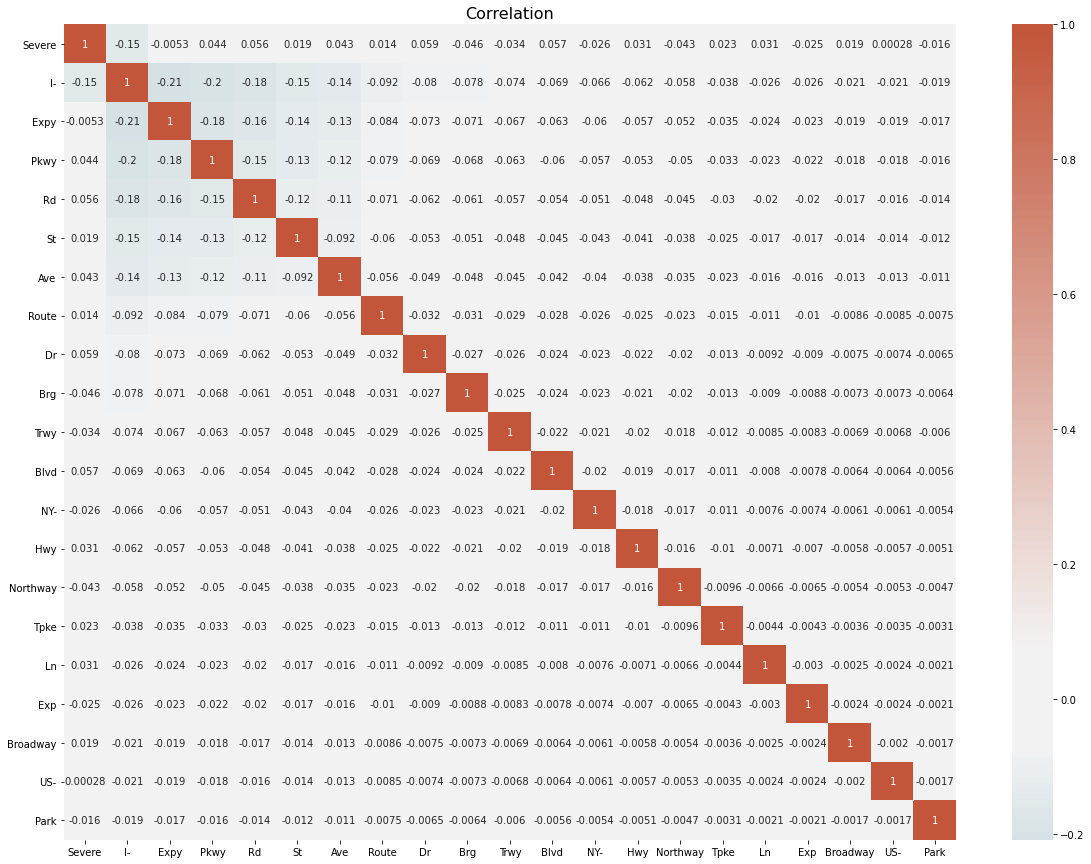

In [225]:
df = NY_2020.copy(deep = True)
for i in Street_type:
    df[i] = np.where(df['Street_type']==i, True, False)

df['Severe'] = np.where(df['Status']=='Severe', True, False)
street_corr  = df.loc[:,['Severe']+[x for x in Street_type]].corr()
plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(street_corr, annot=True, cmap=cmap, center=0).set_title("Correlation", fontsize=16)
plt.show()

# Graph 11
## POI vs. severity Insights: 路况复杂的地方事故相对严重

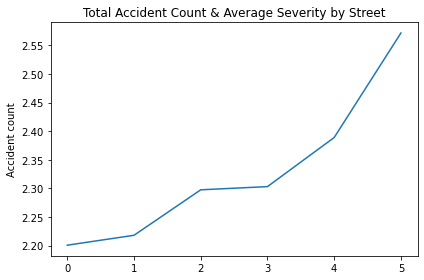

In [25]:
NY_2020["TotalPOI"] = NY_2020.loc[:,'Amenity':'Traffic_Signal'].sum(axis=1)
POI = pd.DataFrame(NY_2020.groupby(['TotalPOI'])['Severity'].mean())

fig, ax = plt.subplots()
x = ['0','1','2','3','4','5']
y = POI['Severity']
ax.plot(x, y)
ax.set_ylabel('Accident count')

plt.title('Total Accident Count & Average Severity by Street')
fig.tight_layout()
plt.show()

# Graph 12
## Severity vs. relative side of the road

Text(0.5, 1.0, 'Accident plot by relative side of street and severity')

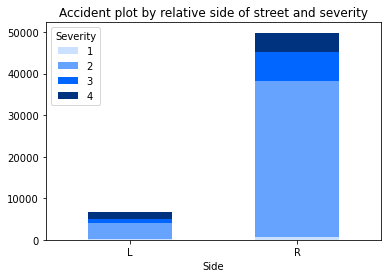

In [27]:
NY.groupby(['Side','Severity']).size().unstack().plot(kind = 'bar', stacked = True, cmap = mpl.colors.ListedColormap(['#CCE0FF', '#66A3FF','#0066FF', '#00337F']))
plt.xticks(rotation=360)
plt.title("Accident plot by relative side of street and severity")

# Formatting for modeling

In [244]:
NY_2020 = NY_2020.drop(["Start_Time",'City','Street','Zipcode','Airport_Code','State', 'Timezone','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight','Streetname','Street_type'], axis=1)

In [245]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()

NY_tmp = NY_2020.copy(deep = True)
NY_tmp[["County","Side","Wind_Direction","Day_Night","DaysOfWeek","Status"]] = ord_enc.fit_transform(NY_tmp[["County","Side","Wind_Direction","Day_Night","DaysOfWeek","Status"]])



In [246]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.2)
selector.fit(NY_tmp)
NY_tmp = NY_tmp[NY_tmp.columns[selector.get_support(indices=True)]]

In [248]:
NY_model = NY_2020[['Severity', 'Start_Lat', 'Start_Lng', 'County', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Cloud', 'Day_Night', 'DaysOfWeek', 'Hour', 'TotalPOI', 'Status']]


In [249]:
NY_model = NY_model.reset_index(drop=True)

In [250]:
NY_model.to_csv('/Users/Xinwei/Desktop/NY_model.csv', index=False)

## Reference
1. https://www.kaggle.com/trivenisaraswathi/severity-prediction-in-sfo-bay-area

2. https://www.kaggle.com/jingzongwang/usa-car-accidents-severity-prediction/notebook

3. https://www.kaggle.com/nikitagrec/usa-accidents-plotly-maps-text-classification/notebook

4. https://www.kaggle.com/mysarahmadbhat/eda-on-us-accidents/notebook
